In [2]:
from ydata_profiling import ProfileReport

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
df = pd.read_csv('../data/data_sorted_by_route.csv')

## Profiling

In [20]:
df = pd.read_csv('../data/data_sorted_by_route.csv')

profile = ProfileReport(df, title="Analysis of the data for preprocessing")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Verifying values distribution in the columnn "distancia"

Float64Index([5650.62, 5647.21, 5643.49, 5637.55, 5636.74, 5633.92, 3282.01,
              3279.84, 3274.61, 3274.44, 3270.65, 3259.89, 3253.24],
             dtype='float64')


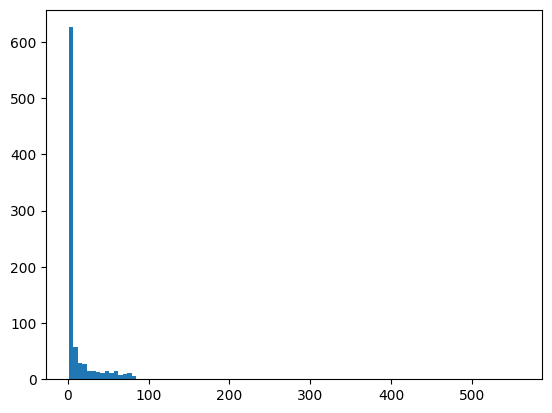

In [21]:
fig, ax = plt.subplots()

print(df['distancia'].value_counts().index.sort_values(ascending=False)[:13])

ax = plt.hist(df['distancia'].value_counts(), bins=100)

plt.show()

## Verifying deliver statistics

### Verifying delivers per routes

Grouping by routes and couting it's number of deliver

In [22]:
df = pd.read_csv('../data/data_sorted_by_route.csv')

grouped_by_route = df.groupby(['codigo_rota']).count().iloc[:,0]

mean_delivers_per_route = round(grouped_by_route.mean())
stdev_delivers_per_route = round(grouped_by_route.std())

Here just filtering routes that have delivered between +-1 standard deviation delivers from the mean

In [23]:
upper_bound = (grouped_by_route > mean_delivers_per_route) & (grouped_by_route < mean_delivers_per_route + stdev_delivers_per_route)
lower_bound = (grouped_by_route < mean_delivers_per_route) & (grouped_by_route > mean_delivers_per_route - stdev_delivers_per_route)
between_one_stdev_filtering_span = upper_bound | lower_bound

grouped_by_route_between_one_stdev = grouped_by_route[between_one_stdev_filtering_span]

between_one_stdev_df = df[df['codigo_rota'].isin(grouped_by_route_between_one_stdev.index)]

bar_graph_labels = {
    'x': 'Código da Rota',
    'y': 'Número de Entregas'
}

fig = px.bar(
    grouped_by_route_between_one_stdev,
    x=grouped_by_route_between_one_stdev.index.astype(str),
    y=grouped_by_route_between_one_stdev.values,
    title='Deliveries per route (for routes that are delivering between 1 standard deviation from the mean)',
    labels=bar_graph_labels)
fig.show()


Here I'm just going to show low and high representative routes, taking only routes that deliver 1 stdev below and 1 stdev over the mean

In [24]:
bellow_one_stdev_filtering_span = grouped_by_route < mean_delivers_per_route - stdev_delivers_per_route
above_one_stdev_filtering_span = grouped_by_route > mean_delivers_per_route + stdev_delivers_per_route

grouped_by_route_bellow_one_stdev = grouped_by_route[bellow_one_stdev_filtering_span]
grouped_by_route_above_one_stdev = grouped_by_route[above_one_stdev_filtering_span]

below_one_stdev_df = df[df['codigo_rota'].isin(grouped_by_route_bellow_one_stdev.index)]

bar_graph_labels = {
    'x': 'Código da Rota',
    'y': 'Número de Entregas'
}

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        'Rotas que estão entregando 1 desvio padrão abaixo da média',
        'Rotas que estão entregando 1 desvio padrão acima da média'
    )
)

fig.add_trace(
    go.Bar(
        x=grouped_by_route_bellow_one_stdev.sort_values().index.astype(str),
        y=grouped_by_route_bellow_one_stdev.sort_values().values
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=grouped_by_route_above_one_stdev.sort_values().index.astype(str),
        y=grouped_by_route_above_one_stdev.sort_values().values
    ),
    row=1, col=2
)

fig.update_layout(height=600, width=1400,
                  title_text="Entregas por rota")

fig.show()

### Verifying deliver per day and time span of 1 hour

In [31]:
df = pd.read_csv('../data/data_sorted_by_route.csv')

df['hora_entrega'] = df['hora_entrega'].astype('datetime64[ns]')
df['dia_entrega'] = df['hora_entrega'].dt.day
df['time_span_entrega'] = df['hora_entrega'].dt.hour

grouped_by_time_span = df.groupby(['time_span_entrega']).count().iloc[:,0]
grouped_by_day = df.groupby(['dia_entrega']).count().iloc[:,0]

bar_graph_labels_time_span = {
    'x': 'Hora da Entrega',
    'y': 'Número de Entregas'
}

bar_graph_labels_day = {
    'x': 'Dia da Entrega',
    'y': 'Número de Entregas'
}

fig_time_span = px.bar(
    grouped_by_time_span,
    x=grouped_by_time_span.index.astype(str),
    y=grouped_by_time_span.values,
    title='Entregas por hora do dia',
    labels=bar_graph_labels_time_span,
    hover_data={
        'Número de Entregas': grouped_by_time_span.values,
        'Hora da Entrega': grouped_by_time_span.index.astype(str)+ ' horas'
    })

fig_day = px.bar(
    grouped_by_day,
    x=grouped_by_day.index.astype(str),
    y=grouped_by_day.values,
    title='Entregras por dia do mês',
    labels=bar_graph_labels_day
)
fig_time_span.show()

### Verifying delivers per CEP

We can do an area plot by cep and time.

To have bigger groups of ceps, we will decide to groupby the first number of cep (ex: 744 -> 7)

In [26]:
df['cep_macro_region_code'] = df['cep'].astype(str).str[0]

df_grouped_by_macro_region = df.groupby(['cep_macro_region_code']).count().iloc[:,0]

bar_graph_labels_day = {
    'x': 'Macro região',
    'y': 'Número de Entregas'
}

fig_bar = px.bar(
    df_grouped_by_macro_region,
    x=df_grouped_by_macro_region.sort_values().index.astype(str),
    y=df_grouped_by_macro_region.sort_values().values,
    title='Deliveries per CEP macro region',
    labels=bar_graph_labels_day
    )

fig_bar.show()

## Modifying columns & feature engeneering

Dealing with the outliers found in column "distancia"

Here we are going to change this observations by the mean of the values for that column that are associated with the same route

In [4]:
# Create auxiliar dict like series to hold mean distance per route
df_temp = df.copy()
df_temp.loc[df['distancia'] > 3000, 'distancia'] = 0.0
df_temp = df_temp.groupby(['codigo_rota']).mean().loc[:,'distancia']

df.loc[df['distancia'] > 3000, 'distancia'] = df['codigo_rota'].map(df_temp)

/tmp/ipykernel_327/3304194358.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df_temp.groupby(['codigo_rota']).mean().loc[:,'distancia']


Feature engeneering

Creating columns
- Hour of day
- Day of month
- CEP macro region
- CEP sub region
- Total de entregas pela rota

In [5]:
# CEP macro region code
df['cep_macro_region_code'] = df['cep'].astype(str).str[0]

# CEP sub region code
df['cep_sub_region_code'] = df['cep'].astype(str).str[1]

# Transforming hora_entrega to datetime
df['hora_entrega'] = df['hora_entrega'].astype('datetime64[ns]')

# Creating columns for day and time span of delivery
df['dia_entrega'] = df['hora_entrega'].dt.day
df['time_span_entrega'] = df['hora_entrega'].dt.hour

df_grouped_by_macro_region = df.groupby(['cep_macro_region_code']).count().iloc[:,0]
grouped_by_route = df.groupby(['codigo_rota']).count().iloc[:,0]

df['total_entregas_rota'] = df['codigo_rota'].map(grouped_by_route)
df['total_entregas_macro_regiao'] = df['cep_macro_region_code'].map(df_grouped_by_macro_region)

df['max_dist_between_deliver'] = df['codigo_rota'].map(df.groupby(['codigo_rota'])['distancia'].max())


### Save new CSV

In [16]:
path_to_csv = '../data/data_clean.csv'
df.to_csv(path_to_csv, index=False)